In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
cars_df = pd.read_csv("car_info_prices.csv")
cars_df.info()
cars_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94256 entries, 0 to 94255
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        94256 non-null  int64  
 1   price       94256 non-null  int64  
 2   mileage     94256 non-null  int64  
 3   tax         94256 non-null  int64  
 4   mpg         94256 non-null  float64
 5   engineSize  94256 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 4.3 MB


,year,price,mileage,tax,mpg,engineSize
count,94256.000000,94256.000000,94256.000000,94256.000000,94256.000000,94256.000000
mean,2017.069311,16777.888718,23209.650049,120.116491,55.228326,1.665003
std,2.107498,9879.543183,21055.158586,63.392410,16.296400,0.559244
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7670.000000,125.000000,47.100000,1.200000
50%,2017.000000,14480.000000,17673.000000,145.000000,54.300000,1.600000
75%,2019.000000,20766.000000,32497.250000,145.000000,62.800000,2.000000
max,2024.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


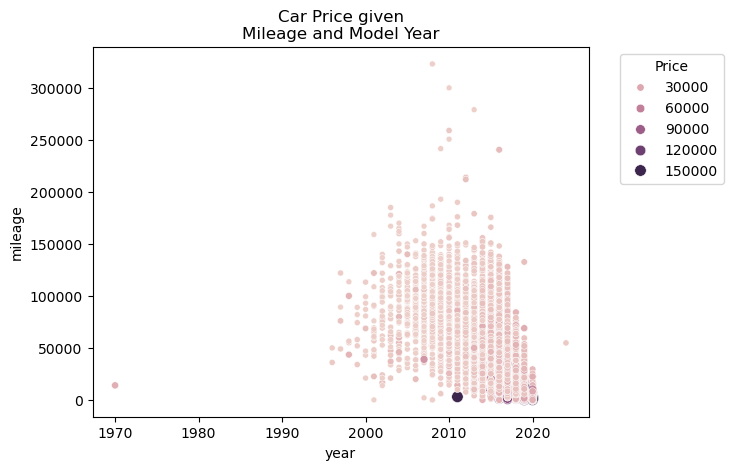

In [3]:
#rng = np.random.RandomState(0)
#indices = rng.choice(np.arange(len(cars_df)), size = 640, replace = False)

sns.scatterplot(x = "year", y = "mileage", data = cars_df, hue = "price", size = "price")

plt.legend(title = "Price", bbox_to_anchor = (1.05, 1), loc = "upper left")
_ = plt.title("Car Price given\nMileage and Model Year")
plt.show()

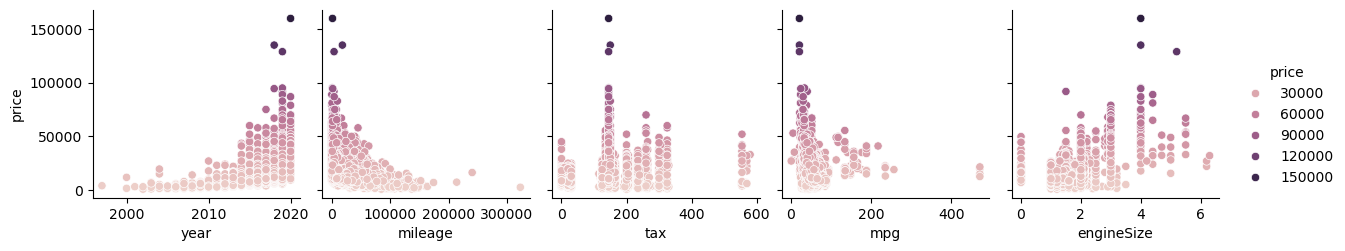

In [4]:
rng = np.random.RandomState(0)
indices = rng.choice(np.arange(len(cars_df)), size = 15000, replace = False)
sns.pairplot(
    data = cars_df.iloc[indices],
    y_vars = ['price'],
    x_vars = list(cars_df.drop(columns = ['price']).columns),
    hue = "price"
)
# this iloc of cars_df is used in the future test predictions
cars_df = cars_df.iloc[indices]
plt.show()

In [5]:
def get_train_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    assert isinstance(X, np.ndarray), f'`X` must be a NumPy array, got type {type(X)} instead.'
    assert isinstance(y, np.ndarray), f'`y` must be a NumPy array, got type {type(y)} instead.'

    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, random_state = 42, test_size = 0.2)
    
    return X_trn, y_trn, X_tst, y_tst

In [6]:
def add_bias(X: np.ndarray) -> np.ndarray:
    """ Add bias term to input features.

        Args:
            X: Input feature data given as a matrix.

        Return: 
            Matrix where first column contains the bias term
    """
    bias = np.ones((len(X), 1))
        
    return np.hstack((bias, X))

In [7]:
def get_preprocessed_data() -> Tuple[np.ndarray]:
    """ Gets preprocessed data for training and testing

        Return:
            A tuple of NumPy arrays where the first two indices 
            contain the training data and targets and the last two
            indicies contain the testing data and targets.
    """
    X = cars_df.drop(columns = ['price'])
    y = cars_df.drop(columns = ["year", "mileage", "tax", "mpg", "engineSize"])
    
    X_trn, y_trn, X_tst, y_tst = get_train_test_data(X.to_numpy(), y.to_numpy())
    
    X_trn = add_bias(X_trn)
    X_tst = add_bias(X_tst)
    
    return X_trn, y_trn, X_tst, y_tst

In [8]:
def sse(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the sum of squared error

        Args:
            y: Ground truth targets given as a 1D vector

            y_hat: Predicted targets given as a 1D vector

    """
    y =  y.reshape(-1,)
    y_hat = y_hat.reshape(-1,)
    
    return np.sum((y_hat - y) ** 2)

In [9]:
def mse(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the mean square error

        Args:
            y: Ground truth targets given as a 1D vector

            y_hat: Predicted targets given as a 1D vector

    """
    y =  y.reshape(-1,)
    y_hat = y_hat.reshape(-1,)
    
    return np.mean((y_hat - y) ** 2)

In [10]:
def rmse(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the root means squared error

        Args:
            y: Ground truth targets given as a 1D vector

            y_hat: Predicted targets given as a 1D vector

    """
    y =  y.reshape(-1,)
    y_hat = y_hat.reshape(-1,)
    
    return np.sqrt(np.mean((y_hat - y) ** 2))

In [11]:
class OrdinaryLeastSquares():
    """ Perfroms ordinary least squares regression
    
        Attributes:
            w: The weights learned by using the normal equation
    """
    def __init__(self):
        self.w  = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        """ Train OLS to learn optimal weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 1D vector

        """
        
        self.w = np.linalg.pinv((X.T @ X)) @ (X.T @ y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Return:
                Returns a 1D vector of predictions for each data sample in X
        """
        
        return X @ self.w

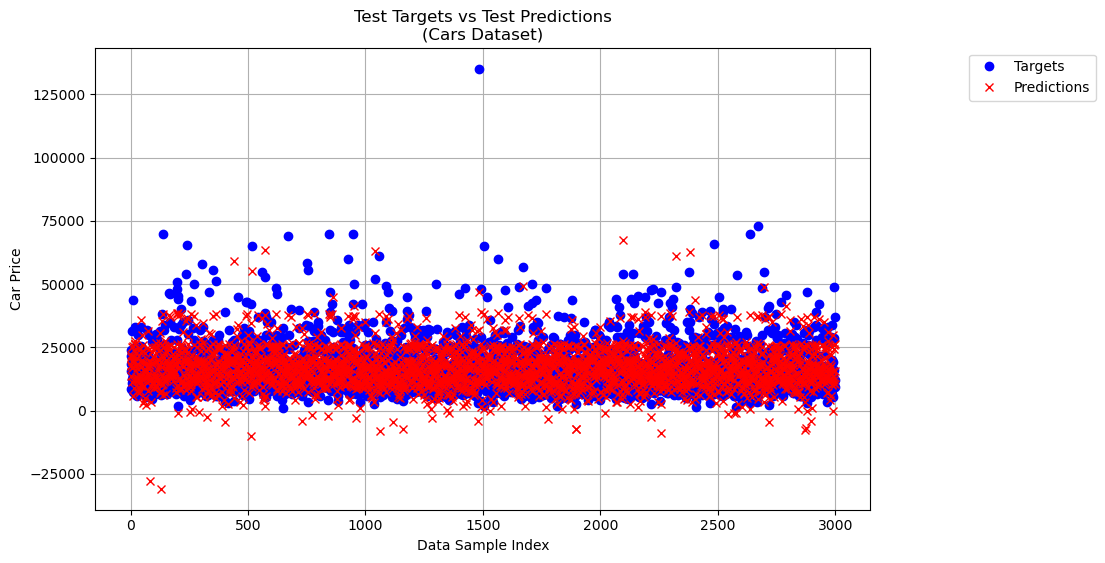

In [12]:
X_trn, y_trn, X_tst, y_tst = get_preprocessed_data()

ols = OrdinaryLeastSquares()

ols.fit(X_trn, y_trn)

y_tst_hat = ols.predict(X_tst)

plt.figure(figsize = (10, 6))
plt.plot(y_tst, 'ob', label = 'Targets')  
plt.plot(y_tst_hat, 'xr', label = 'Predictions')  
plt.xlabel("Data Sample Index")
plt.ylabel("Car Price")
plt.title("Test Targets vs Test Predictions\n(Cars Dataset)")
plt.legend(bbox_to_anchor = (1.3, 1.00))
plt.grid(True)
plt.show()

In [13]:
tst_sse = sse(y_tst, y_tst_hat)

tst_mse = mse(y_tst, y_tst_hat)

tst_rmse = rmse(y_tst, y_tst_hat)

print(f"Test SSE: {tst_sse}")
print(f"Test MSE: {tst_mse}")
print(f"Test RMSE (error in original units): {tst_rmse}")

Test SSE: 103741439239.48253
Test MSE: 34580479.746494174
Test RMSE (error in original units): 5880.516962520742
